In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### **Loading Data**

In [2]:
data = pd.read_csv("SolarPrediction.csv")

In [3]:
data.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


## **Data Wrangling**

In [5]:
df = data.copy()

extract the date from the date_time format of the 'Data' parameter

In [6]:
df["Data"] = df["Data"].apply(lambda x: x.split()[0])

In [7]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [8]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second


In [9]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


Extracting Sunrise information using regular expression

In [10]:
df['risehour'] = df['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(int)
df['riseminute'] = df['TimeSunRise'].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [11]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int32  
 12  Day                     32686 non-null  int32  
 13  Hour                    32686 non-null  int32  
 14  Minute                  32686 non-null

Dropping the parameters that are not required

In [13]:
df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [14]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [15]:
df.shape

(32686, 15)

In [16]:
df.isnull().sum().sum()

0

In [17]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [18]:
np.array(df['Radiation'])

array([1.21, 1.21, 1.23, ..., 1.2 , 1.23, 1.2 ])

In [19]:
input_features = df.drop(['Radiation'], axis=1)
target = df['Radiation']

### Feature Selection Using Correlation Matrix

In [20]:
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


<Axes: >

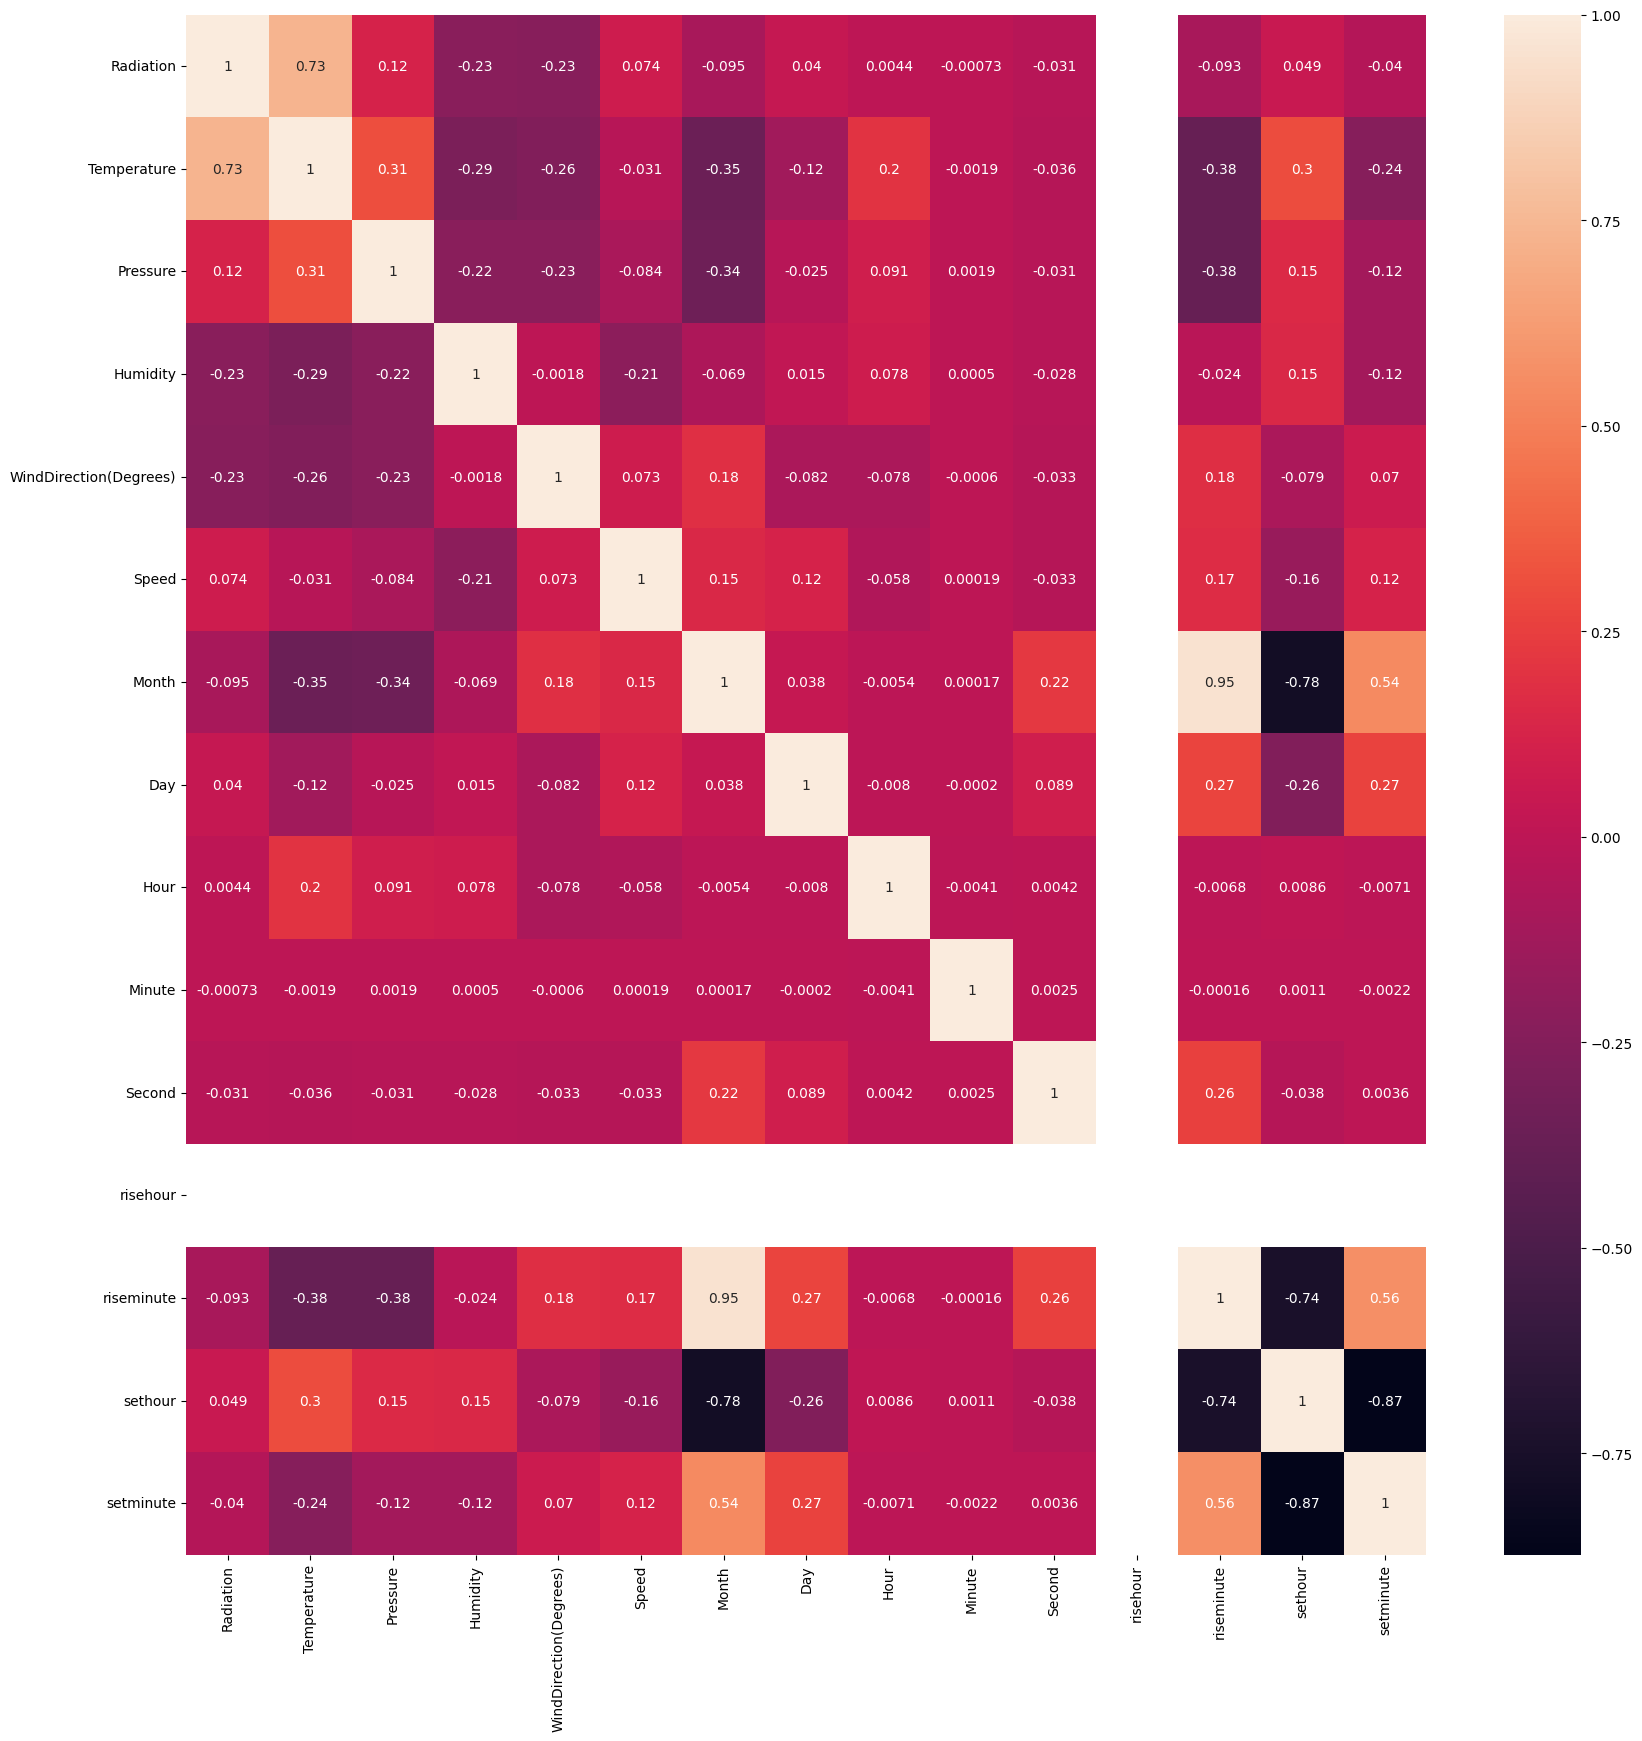

In [21]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

### Feature Selection Using SelectKBest Method

In [22]:
bestfeatures = SelectKBest(score_func=chi2, k=10)

In [23]:
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)
train_Y

array([ 9,  9, 11, ...,  8, 11,  8], dtype=int64)

In [24]:
target_cont = df['Radiation'].apply(lambda x: int(x * 100))
target_cont

0        121
1        121
2        123
3        121
4        117
        ... 
32681    122
32682    117
32683    120
32684    123
32685    120
Name: Radiation, Length: 32686, dtype: int64

In [25]:
scaled_input_features = MinMaxScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [26]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [27]:
featureScores = pd.concat([column, scores], axis=1)

In [28]:
featureScores

,0,0
0,Temperature,1651.685632
1,Pressure,523.791060
2,Humidity,1588.087433
3,WindDirection(Degrees),3271.827277
4,Speed,765.859779
5,Month,4684.579610
6,Day,2841.926850
7,Hour,691.185393
8,Minute,2702.449333
9,Second,2288.673032


In [29]:
featureScores.columns = ['Features', 'feature_imp']

In [30]:
featureScores.sort_values(by='feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminute,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


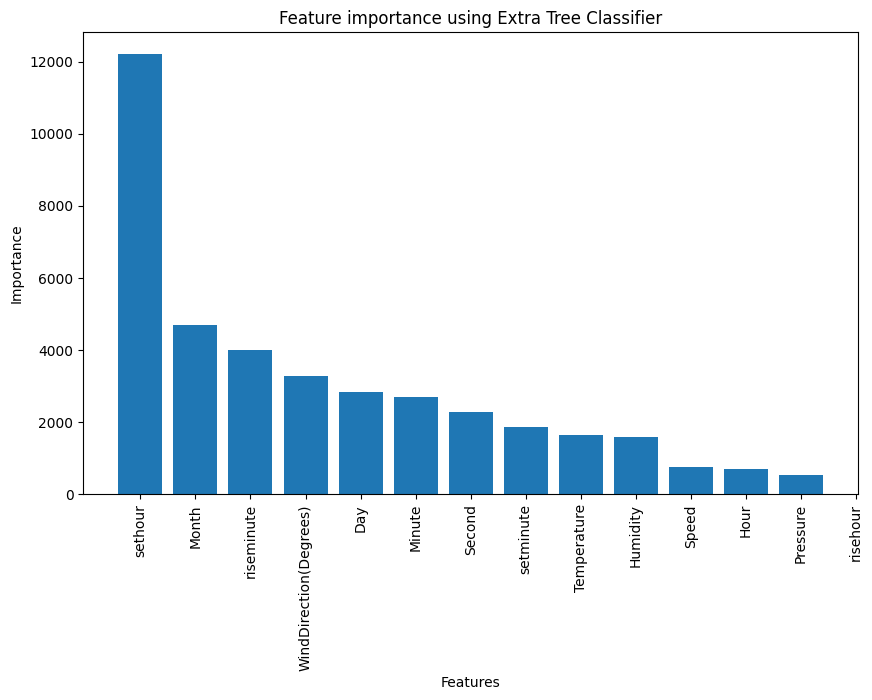

In [31]:
plt.figure(figsize= (10,6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 90) 
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance using Extra Tree Classifier')
plt.show()

### Feature Selection Using Extra Tree Classifier

In [32]:
model = ExtraTreesClassifier(n_estimators=6, verbose=2)
model.fit(scaled_input_features, target_cont)

building tree 1 of 6
building tree 2 of 6
building tree 3 of 6
building tree 4 of 6
building tree 5 of 6
building tree 6 of 6


ExtraTreesClassifier(n_estimators=6, verbose=2)

In [33]:
feature_importances = pd.DataFrame(model.feature_importances_, index=input_features.columns, columns=['feature_imp'])
feature_importances.sort_values(by='feature_imp', ascending=False, inplace=True)
feature_importances

,feature_imp
WindDirection(Degrees),0.159200
Minute,0.147858
Second,0.122245
Speed,0.121889
Humidity,0.108858
Hour,0.091016
Temperature,0.084868
Pressure,0.077511
Day,0.035358
setminute,0.023623


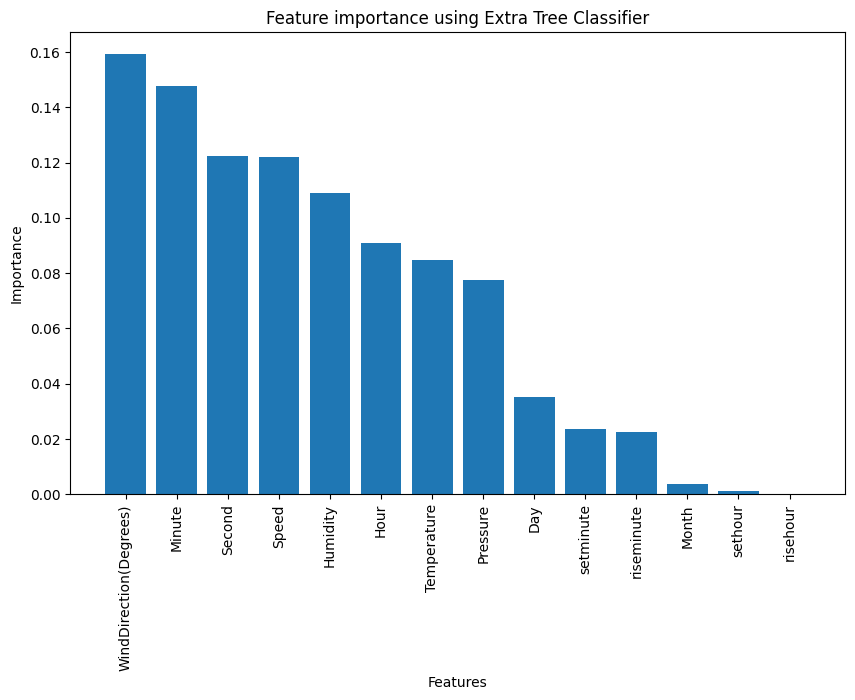

In [34]:
plt.figure(figsize= (10,6))
plt.bar(feature_importances.index, feature_importances['feature_imp'])
plt.xticks(rotation = 90) 
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance using Extra Tree Classifier')
plt.show()

### Feature Engineering With BoxCox, Log, Min-Max and Standard Transformation

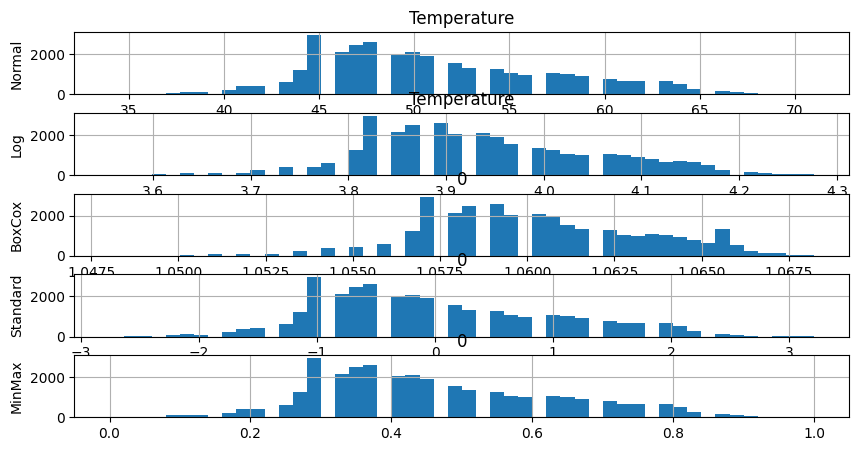

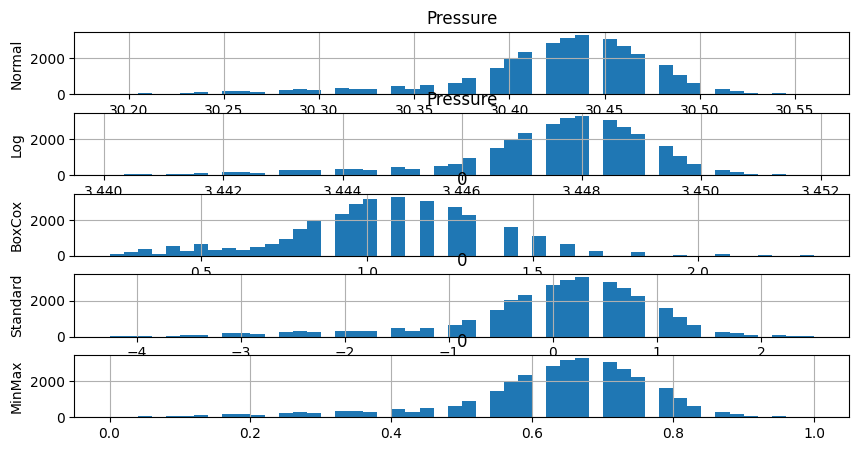

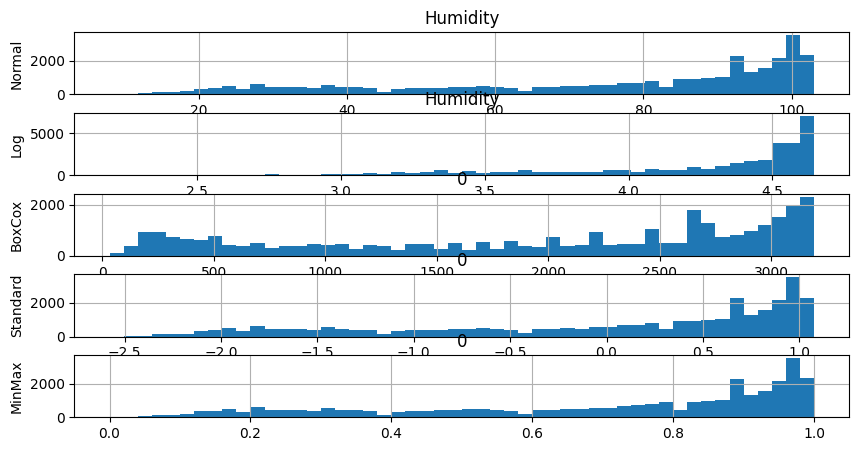

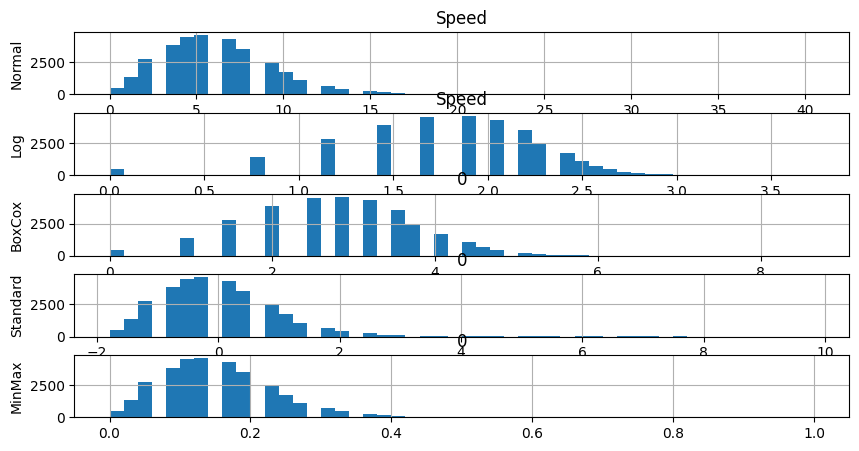

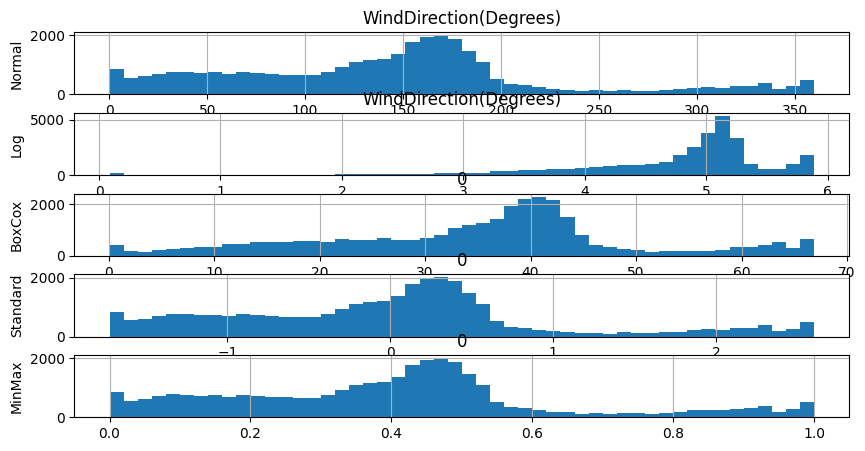

In [35]:
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1 , figsize = (10,5))
    
    pd.DataFrame(input_features[i]).hist(ax=ax1, bins= 50)
    #Log Transformation
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax=ax2, bins= 50)
    #BoxCox Transformation
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax=ax3, bins= 50)
    #Standard Scalar Transformation
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax4, bins= 50)
    #MinMaxScalar Transformation
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax5, bins= 50)

    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('BoxCox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')


In [36]:
transform = {
    "Temperature" : (input_features["Temperature"]+1).transform(np.log),
    "Pressure" : stats.boxcox(input_features['Pressure']+1)[0],
    "Humidity" : stats.boxcox(input_features['Humidity']+1)[0],
    "Speed" : (input_features["Speed"]+1).transform(np.log),
    "WindDirection(Degrees)" : StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))
}

In [37]:
for i in transform:
    input_features[i] = transform[i]

In [38]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,3.89182,1.245832e+297,1139.358153,0.407620,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,1.245832e+297,1104.046486,0.400285,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,1.245832e+297,1069.253069,0.183490,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,1.245832e+297,1175.186958,-0.069497,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,1.245832e+297,1248.391644,-0.463407,1.890095,9,29,23,35,24,6,13,18,13


### Prepairing Data - Standardisation and Splitting

In [39]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)


In [40]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

## XGBoost (Boosting Algorithm)

In [41]:
from xgboost import XGBRegressor

In [42]:
#Declaring the parameters
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

from xgboost import XGBRegressor
model = XGBRegressor(**params)

In [43]:
#training the model
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
y_pred = model.predict(xtest)

In [45]:
print('XGBoost model result: {0:0.4f}'. format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 82.9945


In [46]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 82.99
R2: 0.93


### MultiLayer Perceptron for prediction

In [47]:
input_features.shape

(32686, 14)

In [48]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [50]:
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))

model.compile(metrics=['mse'], loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 209.6295 - mse: 145516.9688 - val_loss: 203.4936 - val_mse: 136437.6406
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 206.7466 - mse: 143029.1250 - val_loss: 202.9973 - val_mse: 136214.2031
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 206.9630 - mse: 143426.2656 - val_loss: 202.9847 - val_mse: 136169.5625
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 208.7570 - mse: 144435.5781 - val_loss: 202.9696 - val_mse: 136112.5156
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 206.2506 - mse: 141780.6250 - val_loss: 202.9533 - val_mse: 136044.4375
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 211.1991 - mse: 146597.9375 - val_loss: 202.9376 - val_mse: 135970.7812
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 206.8107 - mse: 142611.5938 - val_loss: 202.9240 - val_mse: 135897.4844
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 209.9161 - mse: 

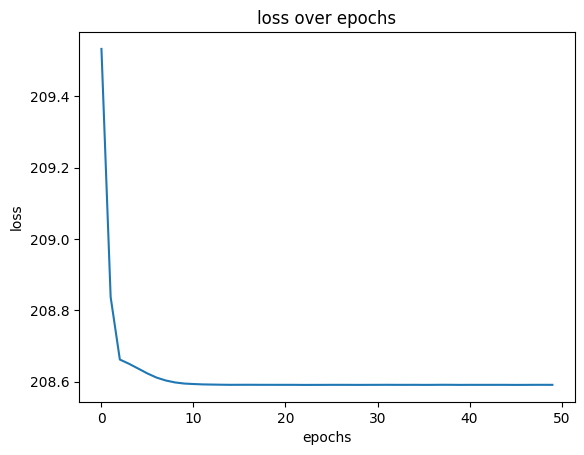

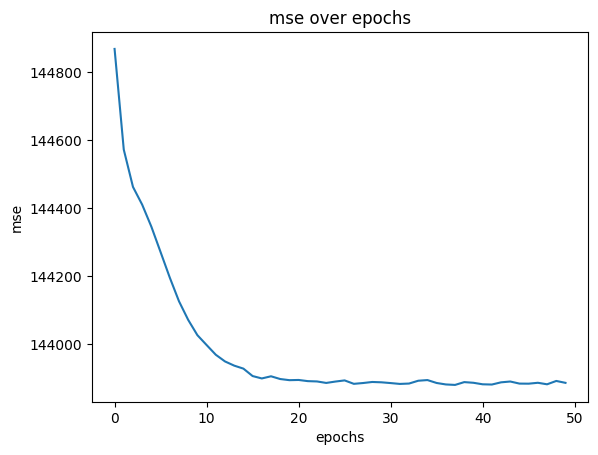

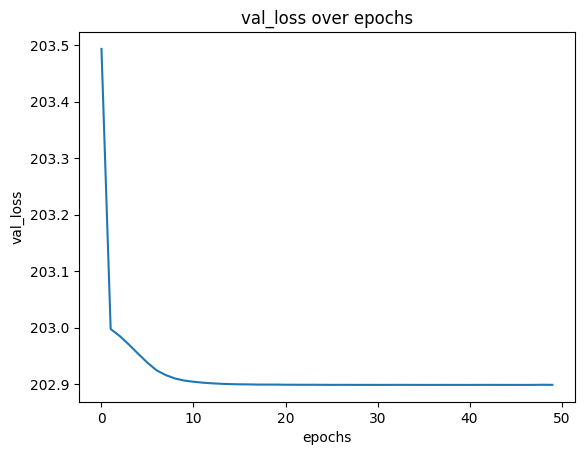

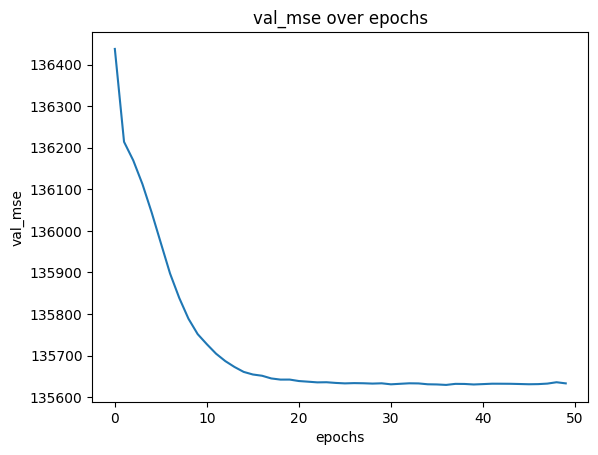

In [56]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [57]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 203.0106 - mse: 139922.7656
Mean absolute error:  197.010498046875


In [58]:
mean_absolute_error(ytest, model.predict(xtest))

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


197.01048515107442